In [1]:
def periodDistance(distance,L = 35000):
    if distance > L/2 :
        return  distance - L
    else:
        if distance < -L/2 :
            return distance + L
        else:
            return distance

In [2]:
def particle_data(basePath,snapNum,subhaloID):
    import numpy as np
    import illustris_python as il
    
    h = 0.677
    
    f1 = 1 / h
    f2 = 10**10 / h
    
    mass_dm = 4.5 * 10**5 / f2
    
    fields = ['Coordinates','Masses']
    fields_dm = ['Coordinates']
    
    subhlaoData = il.groupcat.loadSingle(basePath, snapNum, subhaloID=subhaloID)
    
    cenPos = subhlaoData['SubhaloPos']
    Rm     = subhlaoData['SubhaloVmaxRad'] * f1
    Vm     = subhlaoData['SubhaloVmax']
    
    ParData_gas  = il.snapshot.loadSubhalo(basePath, snapNum, id=subhaloID, partType='gas', fields=fields)
    ParData_star = il.snapshot.loadSubhalo(basePath, snapNum, id=subhaloID, partType='star', fields=fields)
    
    Pos_dm   = il.snapshot.loadSubhalo(basePath, snapNum, id=subhaloID, partType='dm', fields=fields_dm)
    
    if ParData_gas['count'] > 0:
        Pos = np.vstack((ParData_gas['Coordinates'],ParData_star['Coordinates'],Pos_dm))
        Mass= np.hstack((ParData_gas['Masses'],ParData_star['Masses'],np.repeat(mass_dm,Pos_dm.shape[0]))) * f2     # M_{\odot}
        
    else:
        Pos = np.vstack((ParData_star['Coordinates'],Pos_dm))
        Mass= np.hstack((ParData_star['Masses'],np.repeat(mass_dm,Pos_dm.shape[0]))) * f2     # M_{\odot}
    
    
    print('particle number:',Mass.shape[0],Pos.shape[0])
    
    
    Num_sats = Pos.shape[0]
            
    
    for i in np.arange(Num_sats):
        for j in np.arange(3):
            d = Pos[i,j]-cenPos[j]                         # unit ckpc/h
            cDistance = periodDistance(distance=d)         # period box
            Pos[i,j] = cDistance * f1                      # unit kpc
            
    
    return Pos,Mass,Rm,Vm

In [3]:
def particle_data_no_print(basePath,snapNum,subhaloID):
    import numpy as np
    import illustris_python as il
    
    h = 0.677
    
    f1 = 1 / h
    f2 = 10**10 / h
    
    mass_dm = 4.5 * 10**5 / f2
    
    fields = ['Coordinates','Masses']
    fields_dm = ['Coordinates']
    
    subhlaoData = il.groupcat.loadSingle(basePath, snapNum, subhaloID=subhaloID)
    
    cenPos = subhlaoData['SubhaloPos']
    Rm     = subhlaoData['SubhaloVmaxRad'] * f1
    Vm     = subhlaoData['SubhaloVmax']
    
    ParData_gas  = il.snapshot.loadSubhalo(basePath, snapNum, id=subhaloID, partType='gas', fields=fields)
    ParData_star = il.snapshot.loadSubhalo(basePath, snapNum, id=subhaloID, partType='star', fields=fields)
    
    Pos_dm   = il.snapshot.loadSubhalo(basePath, snapNum, id=subhaloID, partType='dm', fields=fields_dm)
    
    if ParData_gas['count'] > 0:
        Pos = np.vstack((ParData_gas['Coordinates'],ParData_star['Coordinates'],Pos_dm))
        Mass= np.hstack((ParData_gas['Masses'],ParData_star['Masses'],np.repeat(mass_dm,Pos_dm.shape[0]))) * f2     # M_{\odot}
        
    else:
        Pos = np.vstack((ParData_star['Coordinates'],Pos_dm))
        Mass= np.hstack((ParData_star['Masses'],np.repeat(mass_dm,Pos_dm.shape[0]))) * f2     # M_{\odot}
    
    
    #print('particle number:',Mass.shape[0],Pos.shape[0])
    
    
    Num_sats = Pos.shape[0]
            
    
    for i in np.arange(Num_sats):
        for j in np.arange(3):
            d = Pos[i,j]-cenPos[j]                         # unit ckpc/h
            cDistance = periodDistance(distance=d)         # period box
            Pos[i,j] = cDistance * f1                      # unit kpc
            
    
    return Pos,Mass,Rm,Vm

In [4]:
def F(r,Radius,Mass):
    
    h = 0.677
    f1 = 6.7 * 10**(-32)              
    rho_c = 1.88 * 10**(-29) * h**2   ## g/cm^(3)
    rho_c /= f1                       ## M_{\odot}/kpc^(3)
    
    index = np.where(Radius<=r)[0]
    N = len(index)
    rho = np.sum(Mass[index])/ (4/3 * np.pi * r**3)  ## M_{\odot}/kpc^(3)
    
    return (np.sqrt(200)/8) * (N/np.log(N)) * (rho_c/rho)**0.5 - 1
    

In [5]:
def half_split(r_m,Radius,Mass,N=10000,e=10**(-6)):
    r_left  = 0
    r_right = r_m
    i = 1
    Arr = np.zeros(2)
    
    while True:
        r_med = (r_left+r_right)/2
        f = F(r_med,Radius,Mass)
        
        Arr[0]=Arr[1]
        Arr[1] = f
        
        if f > 0:
            r_right = r_med
        elif f < 0:
            r_left = r_med
        elif f == 0:
            break
            
        if i>N or np.abs(Arr[1]-Arr[0])<e:
            break
        i+=1
        #print(r_med)
        
    return r_med, f, i
        

In [6]:
def r_partition(r_L,r_R,N):
    arr = np.linspace(np.log(r_L),np.log(r_R),N)
    return np.exp(arr)

In [7]:
def rho_part(Radius,Mass,r_part):
    
    f1 = 1
    
    Rho_part = np.zeros(0)
    for i in np.arange(r_part.shape[0]-1):
        index = np.where((Radius>=r_part[i])&(Radius<r_part[i+1]))[0]
        rho_i = np.sum(Mass[index]) / ((4/3) * np.pi * (r_part[i+1]**3-r_part[i]**3))
        Rho_part = np.append(Rho_part,rho_i)
        
    Rho_part *= f1     # M_{\odot}/kpc^(3)
        
    R_part = (r_part[:-1] + r_part[1:]) / 2 # kpc
    
    return R_part, Rho_part

In [8]:
def rho_model(rho_2, r_2, alpha, r):
    
    return rho_2 * np.exp((-2/alpha) * ((r/r_2)**alpha-1))

def Q2(theta, *arg):
    R_part, Rho_part = arg
    rho_2, r_2, alpha = theta
    return np.mean((np.log(Rho_part)-np.log(rho_model(rho_2, r_2, alpha,R_part)))**2)

def Q_exp(theta, *arg):
    R_part, Rho_part = arg
    rho_2, r_2, alpha, f = theta
    
    sn2 = f**2 * rho_model(rho_2, r_2, alpha,R_part)**2
    
    return 0.5 * np.sum((Rho_part-rho_model(rho_2, r_2, alpha,R_part))**2 / sn2 + np.log(sn2))

In [9]:
def fit(rho_2_e,r_2_e,alpha_e,R_part,Rho_part,bnds):   
    from scipy.optimize import minimize

    initial = np.array([rho_2_e, r_2_e, alpha_e])

    soln = minimize(Q2, initial, args=(R_part, Rho_part),bounds=bnds,method='BFGS',tol=1e-6)
    
    print('success:',soln.success)
    
    return soln.x, soln.fun

In [10]:
def fit_no_bound(rho_2_e,r_2_e,alpha_e,R_part,Rho_part,tol=1e-6):   
    from scipy.optimize import minimize

    initial = np.array([rho_2_e, r_2_e, alpha_e])

    soln = minimize(Q2, initial, args=(R_part, Rho_part),method='BFGS',tol=tol)
    
    print('success:',soln.success)
    
    return soln.x, soln.fun

In [11]:
def fit_no_bound_search(rho_2_e,r_2_e,alpha_e,R_part,Rho_part,tol=1e-6):   
    from scipy.optimize import minimize

    initial = np.array([rho_2_e, r_2_e, alpha_e])

    soln = minimize(Q2, initial, args=(R_part, Rho_part),method='BFGS',tol=tol)
    
    #print('success:',soln.success)
    
    return soln.fun,soln.success

In [12]:
def fit_exp_no_bound(rho_2_e,r_2_e,alpha_e,f_e,R_part,Rho_part,tol=1e-6):   
    from scipy.optimize import minimize

    initial = np.array([rho_2_e, r_2_e, alpha_e, f_e])

    soln = minimize(Q_exp, initial, args=(R_part, Rho_part),method='BFGS',tol=tol)
    
    print('success:',soln.success)
    
    return soln.x, soln.fun

In [13]:
def Func(rho_2, r_2, alpha):
        
    return lambda r: r**2 * rho_model(rho_2, r_2, alpha, r)

In [14]:
def circular_v2(r,rho_2, r_2, alpha):
    from scipy import integrate
    
    G  = 6.7 * 10**(-8)
    f1 = 64.5 
    
    y,err = integrate.quad(Func(rho_2, r_2, alpha),0,r)
    
    return (4*np.pi*G / r) * y * f1   #(km/s)^{2}

In [15]:
def rotation_curve(basePath,snapNum,subhaloID,f = 90,N_grade = 200):
    import numpy as np
    
    G = 6.7 * 10**(-8)
    #width = 0.5  
    r_lim_l = 0.05 #kpc
    r_lim_h = 1.2 
    
    f1 = 1.04 * 10**(-33)
    f2 = 6.7 * 10**(-32)
    V2 = np.zeros(0)
    
    Pos,Mass,r_m,v_m = particle_data(basePath,snapNum,subhaloID)
    Radius = np.linalg.norm(Pos,axis=1)
   
    r_R = np.percentile(Radius,f)
    
    r_med, func, i = half_split(r_R,Radius,Mass,N=10000,e=10**(-6))
    print('r_med, r_R, func:',r_med, r_R, func)
    
    print('number ration of r_med-r_R:', np.where((Radius>=r_med)&(Radius<=r_R))[0].shape[0]/Mass.shape[0])
    
#     r_part = r(r_L=r_med,r_max=f*r_m,N=Mass.shape[0]/s)
    
    r_part = r_partition(r_L=r_med, r_R=r_R, N=N_grade)
    
    R_part, Rho_part = rho_part(Radius,Mass,r_part)
    
    
    r_2_e   = r_m / 2.1 
    rho_2_e = v_m**2 / (11.19 * G * r_2_e**2) 
    rho_2_e = rho_2_e * f1 / f2 #M_{\odot}kpc^{3}
    alpha_e = 0.18
    
#     b_rho =   (rho_2_e-width*rho_2_e, rho_2_e+width*rho_2_e)
#     b_r =     (r_2_e-width*r_2_e, r_2_e+width*r_2_e)
#     b_alpha = (alpha_e-width*alpha_e , alpha_e+width*alpha_e)
    
#     bnds = (b_rho,b_r,b_alpha)
    
#     rho_2,r_2,alpha = fit(rho_2_e,r_2_e,alpha_e,R_part,Rho_part,bnds)

    par,fun_value = fit_no_bound(rho_2_e,r_2_e,alpha_e,R_part,Rho_part,tol=1e-4)
    
    print('fit error:',fun_value)
    
    rho_2,r_2,alpha = par
    
    print("rho_2,r_2,alpha",rho_2,r_2,alpha)
    
    r_arr = np.linspace(r_lim_l,r_lim_h,20)
    
    for r_i in r_arr:
        V2 = np.append(V2,circular_v2(r_i,rho_2, r_2, alpha))
        
    
    return r_arr, np.sqrt(V2)
    

In [16]:
def rotation_curve_search(basePath,snapNum,subhaloID,f = 90,N_grade = 200):
    import numpy as np
    
    G = 6.7 * 10**(-8)
    #width = 0.5  
    r_lim_l = 0.05 #kpc
    r_lim_h = 1.2 
    
    f1 = 1.04 * 10**(-33)
    f2 = 6.7 * 10**(-32)
    V2 = np.zeros(0)
    
    Pos,Mass,r_m,v_m = particle_data_no_print(basePath,snapNum,subhaloID)
    Radius = np.linalg.norm(Pos,axis=1)
   
    r_R = np.percentile(Radius,f)
    
    r_med, func, i = half_split(r_R,Radius,Mass,N=10000,e=10**(-6))
    #print('r_med, r_R, func:',r_med, r_R, func)
    
    #print('number ration of r_med-r_R:', np.where((Radius>=r_med)&(Radius<=r_R))[0].shape[0]/Mass.shape[0])
    
#     r_part = r(r_L=r_med,r_max=f*r_m,N=Mass.shape[0]/s)
    
    r_part = r_partition(r_L=r_med, r_R=r_R, N=N_grade)
    
    R_part, Rho_part = rho_part(Radius,Mass,r_part)
    
    
    r_2_e   = r_m / 2.1 
    rho_2_e = v_m**2 / (11.19 * G * r_2_e**2) 
    rho_2_e = rho_2_e * f1 / f2 #M_{\odot}kpc^{3}
    alpha_e = 0.18
    
#     b_rho =   (rho_2_e-width*rho_2_e, rho_2_e+width*rho_2_e)
#     b_r =     (r_2_e-width*r_2_e, r_2_e+width*r_2_e)
#     b_alpha = (alpha_e-width*alpha_e , alpha_e+width*alpha_e)
    
#     bnds = (b_rho,b_r,b_alpha)
    
#     rho_2,r_2,alpha = fit(rho_2_e,r_2_e,alpha_e,R_part,Rho_part,bnds)

    fun_value, success = fit_no_bound_search(rho_2_e,r_2_e,alpha_e,R_part,Rho_part,tol=1e-4)
    
    
    
    return fun_value, success
    

In [17]:
def rotation_curve_exp(basePath,snapNum,subhaloID,f = 90,N_grade = 200):
    import numpy as np
    
    G = 6.7 * 10**(-8)
    #width = 0.5  
    r_lim_l = 0.05 #kpc
    r_lim_h = 1.2 
    
    f1 = 1.04 * 10**(-33)
    f2 = 6.7 * 10**(-32)
    V2 = np.zeros(0)
    
    Pos,Mass,r_m,v_m = particle_data(basePath,snapNum,subhaloID)
    Radius = np.linalg.norm(Pos,axis=1)
   
    r_R = np.percentile(Radius,f)
    
    r_med, func, i = half_split(r_R,Radius,Mass,N=10000,e=10**(-6))
    print('r_med, r_R, func:',r_med, r_R, func)
    
    print('number ration of r_med-r_R:', np.where((Radius>=r_med)&(Radius<=r_R))[0].shape[0]/Mass.shape[0])
    
#     r_part = r(r_L=r_med,r_max=f*r_m,N=Mass.shape[0]/s)
    
    r_part = r_partition(r_L=r_med, r_R=r_R, N=N_grade)
    
    R_part, Rho_part = rho_part(Radius,Mass,r_part)
    
    
    r_2_e   = r_m / 2.1 
    rho_2_e = v_m**2 / (11.19 * G * r_2_e**2) 
    rho_2_e = rho_2_e * f1 / f2 #M_{\odot}kpc^{3}
    alpha_e = 0.18
    f_e = 1
    
#     b_rho =   (rho_2_e-width*rho_2_e, rho_2_e+width*rho_2_e)
#     b_r =     (r_2_e-width*r_2_e, r_2_e+width*r_2_e)
#     b_alpha = (alpha_e-width*alpha_e , alpha_e+width*alpha_e)
    
#     bnds = (b_rho,b_r,b_alpha)
    
#     rho_2,r_2,alpha = fit(rho_2_e,r_2_e,alpha_e,R_part,Rho_part,bnds)

    par,fun_value = fit_exp_no_bound(rho_2_e,r_2_e,alpha_e,f_e,R_part,Rho_part,tol=1e-4)
    rho_2,r_2,alpha,f_fit = par
    
    print('fit error:',fun_value,'f_fit:',f_fit)
    print("rho_2,r_2,alpha",rho_2,r_2,alpha)
    
    
    
    r_arr = np.linspace(r_lim_l,r_lim_h,20)
    
    for r_i in r_arr:
        V2 = np.append(V2,circular_v2(r_i,rho_2, r_2, alpha))
        
    
    return r_arr, np.sqrt(V2)
    

In [18]:
def rotation_curve_raw_data(basePath,snapNum,subhaloID):
    import numpy as np
    
    G = 6.7 * 10**(-8)
    f1 = 64.5 
    r_lim_l = 0.05
    r_lim_h = 1.2
       
    M  = np.zeros(0)
    V2 = np.zeros(0)
    
    Pos,Mass,r_m,v_m = particle_data(basePath,snapNum,subhaloID)
    Radius = np.linalg.norm(Pos,axis=1)
    
    r_arr = np.linspace(r_lim_l,r_lim_h,20)
    
    for r_i in r_arr:
        index = np.where(Radius<=r_i)[0]
        M = np.append(M,np.sum(Mass[index]))
        
    V2 = G * M / r_arr * f1
    
    return r_arr, np.sqrt(V2)
    

### calculate and plot

In [19]:
import numpy as np


ids_19 = np.array([ 589874,  589875,  589888,  589895,  589877,  589906,  589945,
                 589901,  589876,  589894,  589904,  589898,  589884,  589878,
                 589899,  589892, 1075833,  589883,  589891])

name = ['Carina','Draco','Fornax','LeoI','LeoII','Sculptor','Sextans','UrsMin','CVnI']
R_h = np.array([334, 291, 944, 388, 233, 375, 1019, 588, 750])    #pc
R_h_error = np.array([37, 14, 53, 64, 17, 54, 62, 58, 48])

V_dis = np.array([6.4, 10.1, 10.7, 9, 6.6, 9, 7.1, 11.5, 7.6])    #km/s
V_dis_error = np.array([0.2, 0.5, 0.2, 0.4, 0.5, 0.2, 0.3, 0.6, 0.5])

In [20]:
import numpy as np
Address = '/home/tnguser/data/infall_time_14.npz'
basePath = '/home/tnguser/sims.TNG/TNG50-1/output/'
snapNum  = 99
data = dict(np.load(Address))

index = np.where(data['GroupID']==395)[0]
ids = data['Sat_IDs'][index][0]

i1 = [0,1,4,8]
i2 = [11,12,13,16,17,18]
i3 = [2,3,5,6,7,10]
ids_fit = ids_19[i1]
ids_fit_exp = ids_19[i2]
ids_raw = ids_19[i3]

In [21]:
R   = np.zeros((0,20))
V_c = np.zeros((0,20))

for Id in  ids_fit:
    r,v = rotation_curve(basePath,snapNum,subhaloID=Id,f = 90,N_grade = 100)
    R   = np.append(R,r.reshape(1,20),axis=0)
    V_c = np.append(V_c,v.reshape(1,20),axis=0)
    
for Id in  ids_fit_exp:
    r,v = rotation_curve_exp(basePath,snapNum,subhaloID=Id,f = 95,N_grade = 100)
    R   = np.append(R,r.reshape(1,20),axis=0)
    V_c = np.append(V_c,v.reshape(1,20),axis=0)

for Id in  ids_raw:
    r,v = rotation_curve_raw_data(basePath,snapNum,subhaloID=Id)
    R   = np.append(R,r.reshape(1,20),axis=0)
    V_c = np.append(V_c,v.reshape(1,20),axis=0)
    print(Id)

r,v = rotation_curve_exp(basePath,snapNum,subhaloID=ids_19[15],f = 97,N_grade = 80)
R   = np.append(R,r.reshape(1,20),axis=0)
V_c = np.append(V_c,v.reshape(1,20),axis=0)

r,v = rotation_curve(basePath,snapNum,subhaloID=ids_19[14],f = 98,N_grade = 7)
R   = np.append(R,r.reshape(1,20),axis=0)
V_c = np.append(V_c,v.reshape(1,20),axis=0)

r,v = rotation_curve_exp(basePath,snapNum,subhaloID=ids_19[9],f = 95,N_grade = 400)
R   = np.append(R,r.reshape(1,20),axis=0)
V_c = np.append(V_c,v.reshape(1,20),axis=0)

particle number: 20066 20066
r_med, r_R, func: 1.91713184368 31.4989249944 -7.27854192362e-07
number ration of r_med-r_R: 0.8371374464267916
success: True
fit error: 0.01239670356431808
rho_2,r_2,alpha 902394.390097 5.00555705463 0.226485315108
particle number: 8132 8132
r_med, r_R, func: 2.0835198674 14.9204830191 3.80203924566e-07
number ration of r_med-r_R: 0.7293408755533693
success: True
fit error: 0.0189883705670972
rho_2,r_2,alpha 6201920.44329 2.07170395805 0.252247587789
particle number: 3797 3797
r_med, r_R, func: 2.21507840707 9.29119071939 -7.06288042163e-07
number ration of r_med-r_R: 0.5996839610218594
success: True
fit error: 0.05623309990178994
rho_2,r_2,alpha 9239899.71369 1.58043469197 0.424489315128
particle number: 4394 4394
r_med, r_R, func: 2.31704286469 12.0232291772 8.14290586071e-08
number ration of r_med-r_R: 0.667501137915339
success: True
fit error: 0.03898878219353615
rho_2,r_2,alpha 5403128.83798 1.95680113037 0.388746112385
particle number: 521 521
r_med,

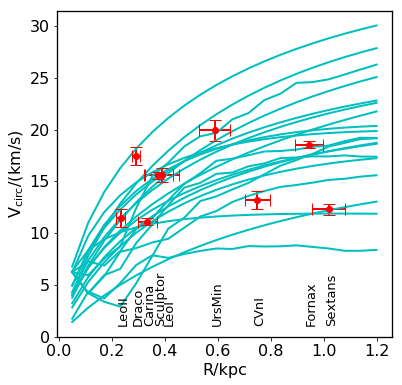

In [23]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (6,6))

f = 1 / 1000
f1 = np.sqrt(3)

i = 14
for i in np.arange(R.shape[0]):
    ax.plot(R[i],V_c[i],'-c',linewidth=2)
# ax.plot(R[i],V_c[i],'-c')
        
for i in np.arange(R_h.shape[0]):
    ax.errorbar(x=R_h[i]*f,y=V_dis[i]*f1,xerr=R_h_error[i]*f,yerr=V_dis_error[i]*f1,
               fmt='or', linewidth=2, capsize=6)
    
for i in np.arange(R_h.shape[0]):
    if i == 3:
        ax.text(R_h[i]*f+0.03,1,name[i],ha='center', va='bottom',rotation=90, size=13)
        continue
        
    ax.text(R_h[i]*f+0.01,1,name[i],ha='center', va='bottom',rotation=90, size=13)
    
ax.set_xlabel('R/kpc',fontsize=16)
ax.set_ylabel(r'$\mathrm{V_{circ}/(km/s)}$',fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.spines['left'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['right'].set_linewidth(1.3)